In [394]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
### for reproducible experiments
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [395]:
import numpy as np
import pandas as pd
import git
import mlflow.keras
import os, sys
from gensim.models.wrappers import FastText

#import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import random
%matplotlib inline
pd.set_option('display.max_rows', None)
from tqdm import tqdm
sys.path.append('../citation_bio_trainer')
#from feature.SpacyFeaturizer import get_spacy_feats_from_text
from feature.Featurizer import Featurizer
from util.Utils import calulate_ser_jer, load_from_folder, pad_sequences, load_embedding_matrix, evaluate, log_mlflow_results
import warnings
from model.FTLSTM import calulate_ser_jer, get_model, plot_output
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## LSTM with random embedding model

In [30]:
%%time
train_data_path = '/nlp/cs_mixed_20k/cs_mixed_20k_train/'
test_data_path  = '/nlp/cs_mixed_20k/cs_mixed_20k_test/'
eval_without_intra_newline_path  = '/nlp/eval_data_spacy_tokenized_extra_space_removed/'

sentences_train, sent_tags_train = load_from_folder(train_data_path)
sentences_test, sent_tags_test = load_from_folder(test_data_path)
sentences_eval1, sent_tags_eval1 = load_from_folder(eval_without_intra_newline_path)

CPU times: user 1min 30s, sys: 461 ms, total: 1min 30s
Wall time: 1min 30s


### Create new dataset with sliding window 

In [31]:
def sliding_window_seq(sequence, tags=[], winSize=100,step=1, has_tags=True):
    out_seq = []
    out_tags = []
    if step > winSize:
        print("step bigger than window")
        
    numOfChunks = int(((len(sequence)-winSize)/step)+2)
    if has_tags:
        for i in range(0,numOfChunks*step,step):
            out_seq.append(" ".join(sequence[i:i+winSize]))
            out_tags.append(" ".join(tags[i:i+winSize]))
    else:
        for i in range(0,numOfChunks*step,step):
            out_seq.append(" ".join(sequence[i:i+winSize]))
        
    return out_seq, out_tags

def sliding_window_list(sequence_list, tag_list=[], winSize=100, step=90, has_tags=True):
    out_seq_list = []
    out_tag_list = []
    for seq, tags in tqdm(zip(sequence_list, tag_list)):
        newseq, newtags = sliding_window_seq(seq.split(" "), tags.split(" "), winSize, step)
        out_seq_list.append(newseq)
        out_tag_list.append(newtags)
    return out_seq_list, out_tag_list

In [32]:
%%time
sentences_train_win, sent_tags_train_win = sliding_window_list(sentences_train, sent_tags_train)
sentences_test_win, sent_tags_test_win = sliding_window_list(sentences_test, sent_tags_test)
sentences_eval1_win, sent_tags_eval1_win = sliding_window_list(sentences_eval1, sent_tags_eval1)

17575it [00:03, 5512.66it/s]
1953it [00:00, 5800.91it/s]
1328it [00:00, 3100.92it/s]

CPU times: user 3.97 s, sys: 20.6 ms, total: 3.99 s
Wall time: 3.98 s


In [316]:
len(sentences_eval1[0].split(" "))

597

In [318]:
sentences_eval1_win[1]

'Placenta . 1996;17:37 - 48 . \n 3 . Salafia CM , Ernst LM , Pezzullo JC , Wolf EJ , Rosenkrantz TS , Vintzileos AM . The very low birthweight infant : maternal complications leading to preterm birth , placental lesions , and intrauterine growth . Am J Perinatol . 1995;12:106 - 10 . \n 4 . Salgado SS , Salgado MKR . Structural changes in pre - eclamptic and eclamptic placentas - an ultrastructural study . J Coll Physicians Surg Pak . 2011;21:482 - 6 . \n 5 . Higgins M , Felle P , Mooney EE ,'

In [33]:
%%time
### Flatten the 3d list to 2d
sentences_train_win = [item for sublist in sentences_train_win for item in sublist]
sent_tags_train_win = [item for sublist in sent_tags_train_win for item in sublist]

sentences_test_win = [item for sublist in sentences_test_win for item in sublist]
sent_tags_test_win = [item for sublist in sent_tags_test_win for item in sublist]

sentences_eval1_win = [item for sublist in sentences_eval1_win for item in sublist]
sent_tags_eval1_win = [item for sublist in sent_tags_eval1_win for item in sublist]

CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 54.8 ms


In [61]:
len(sentences_test_win)

20784

In [34]:
xtrain, xvalid, ytrain, yvalid = train_test_split(sentences_train_win, sent_tags_train_win, test_size=0.1, random_state=42)

In [414]:
feat_config = {'max_vocab':100000,
               'lstm_feats':True, 
               'spacy_feats':False, 
               'google_feats': False, 
               'parscit_feats': False,
              'custom_feats': False, 
              'window':100,
              'step':90}

In [36]:
%%time
featurizer = Featurizer(feat_config)
print("loading train ...")
train_dict, tokenizer, maxlen = featurizer.fit_transform(xtrain, ytrain)
print("loading valid ...")
valid_dict = featurizer.transform(xvalid, yvalid)
print("loading test ...")
test_dict  = featurizer.transform(sentences_test_win, sent_tags_test_win)
print("loading evals ...")
eval1_dict  = featurizer.transform(sentences_eval1_win, sent_tags_eval1_win)

loading train ...
loading valid ...
loading test ...
loading evals ...
CPU times: user 56.1 s, sys: 912 ms, total: 57 s
Wall time: 57 s


In [64]:
test_dict['lstm_feats'].shape

(20784, 100)

In [37]:
# %%time
# ### Load from file
# maxlen = 3861
# train_dict={}
# train_dict['labels'] = np.load('/nlp/temp/train_dict_labels.npy')
# train_dict['lstm_feats']=np.load('/nlp/temp/train_dict_lstm_feats.npy')
# train_dict['spacy_num_feats'] = np.load('/nlp/temp/train_dict_spacy_feats.npy')

# valid_dict={}
# valid_dict['labels']=np.load('/nlp/temp/valid_dict_labels.npy')
# valid_dict['lstm_feats']=np.load('/nlp/temp/valid_dict_lstm_feats.npy')
# valid_dict['spacy_num_feats']=np.load('/nlp/temp/valid_dict_spacy_feats.npy')

# test_dict={}
# test_dict['labels'] = np.load('/nlp/temp/test_dict_labels.npy')
# test_dict['lstm_feats']=np.load('/nlp/temp/test_dict_lstm_feats.npy')
# test_dict['spacy_num_feats']=np.load('/nlp/temp/test_dict_spacy_feats.npy')

# eval1_dict={}
# eval1_dict['labels'] = np.load('/nlp/temp/eval1_dict_labels.npy')
# eval1_dict['lstm_feats']=np.load('/nlp/temp/eval1_dict_lstm_feats.npy')
# eval1_dict['spacy_num_feats']=np.load('/nlp/temp/eval1_dict_spacy_feats.npy')

In [38]:
# def get_custom_feats(data_ls, maxlen):
#     feat_arr = np.zeros((len(data_ls), maxlen, 5), dtype='int8') #[[[0]* 5]* maxlen]* len(data_ls)
#     for ind in tqdm(range(len(data_ls))):
#         sent_ls = data_ls[ind].split(" ") 
#         for i in range(len(sent_ls) - 2):
#             if i>= maxlen:
#                 break
#             if i == 0:
#                 feat_arr[ind][i][0] = 1
#             elif sent_ls[i-1] == '\n':
#                 if sent_ls[i].isdigit() and len(sent_ls[i]) <= 2 and sent_ls[i+1] in ('.', ')'):
#                     feat_arr[ind][i][1] = 1
#                 elif sent_ls[i].isalpha() and len(sent_ls[i]) == 1 and sent_ls[i+1] in ('.', ')'):
#                     feat_arr[ind][i][2] = 1
#                 elif sent_ls[i] in ('[', '(') and (sent_ls[i+1].isdigit() and len(sent_ls[i+1]) <=2) and sent_ls[i+2] in (']', ')'):
#                     feat_arr[ind][i][3] = 1
#                 elif sent_ls[i] in ('[', '(') and (sent_ls[i+1].isalpha() and len(sent_ls[i+1]) ==2) and sent_ls[i+2] in (']', ')'):
#                     feat_arr[ind][i][4] = 1
#     return feat_arr#.reshape(len(data_ls), maxlen, 1)

In [39]:
# %%time
# train_custom_arr = get_custom_feats(xtrain, maxlen)
# valid_custom_arr = get_custom_feats(xvalid, maxlen)
# test_custom_arr = get_custom_feats(sentences_test, maxlen)
# eval1_custom_arr = get_custom_feats(sentences_eval1, maxlen)

### Neural parscit features (temporary fix)

In [40]:
# %%time
# from feature.ParsCitLSTM import ParsCitLSTM
# c = {
#         "model_file": "/nlp/parscit/parscit-29-latest.h5",
#         "label_dict_file": "/nlp/parscit/labels.json",
#         "tfhub_model_dir": "/nlp/parscit/resource/"}
# model = ParsCitLSTM(model_config=c)

In [41]:
# %%time
# train_df = pd.DataFrame([])
# valid_df = pd.DataFrame([])
# test_df = pd.DataFrame([])
#eval1_df = pd.DataFrame([])

# train_df['text'] = np.array(xtrain, dtype='object')
# valid_df['text'] = np.array(xvalid, dtype='object')
# test_df['text'] = np.array(sentences_test, dtype='object')
#eval1_df['text'] = np.array(sentences_eval1, dtype='object')

In [42]:
#%%time
# train_parscit = model.get_parscit_blocks(train_df)
# valid_parscit = model.get_parscit_blocks(valid_df)
# test_parscit  = model.get_parscit_blocks(test_df)
#eval1_parscit = model.get_parscit_blocks(eval1_df, chunk_size=40)


# train_parscit = pd.read_pickle('/nlp/temp/train_parscit.pickle')
# valid_parscit = pd.read_pickle('/nlp/temp/valid_parscit.pickle')
# test_parscit = pd.read_pickle('/nlp/temp/test_parscit.pickle')
# eval1_parscit = pd.read_pickle('/nlp/temp/eval1_parscit.pickle')

In [43]:
# def pad_dummy_feats(df, maxlen):
#     parscit = df.copy()
#     parscit_feats = list(parscit['parscit_feat']) 
#     parscit_padded = []
#     for ind in range(len(parscit_feats)):
#         parscit_mask = np.zeros((maxlen, 14), dtype='int8')
#         if len(parscit_feats[ind]) <= maxlen:
#             parscit_mask[0:len(parscit_feats[ind]), :] = parscit_feats[ind][:]
#         else:
#             parscit_mask[:] = parscit_feats[ind][0:maxlen,:]
#         parscit_padded.append(parscit_mask)
#     parscit_arr = np.array([i.tolist() for i in parscit_padded])
#     return parscit_arr

In [44]:
# %%time
# train_parscit_arr = pad_dummy_feats(train_parscit, maxlen)
# valid_parscit_arr = pad_dummy_feats(valid_parscit, maxlen)
# test_parscit_arr  = pad_dummy_feats(test_parscit, maxlen)
#eval1_parscit_arr = pad_dummy_feats(eval1_parscit, maxlen)

In [45]:
# %%time
# ## load saved files
# train_parscit_arr = np.load('/nlp/temp/train_parscit_arr.npy')
# valid_parscit_arr = np.load('/nlp/temp/valid_parscit_arr.npy')
# test_parscit_arr  = np.load('/nlp/temp/test_parscit_arr.npy')
# eval1_parscit_arr = np.load('/nlp/temp/eval1_parscit_arr.npy')

## Keras with pre-trained fast text embedding

In [46]:
#maxlen=100

In [47]:
%%time
#wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')
#embedding_matrix = load_embedding_matrix(wiki_model, feat_config['max_vocab'], tokenizer.word_index, 300)
embedding_matrix=np.load('/nlp/temp/embedding_matrix.npy')

CPU times: user 0 ns, sys: 91.9 ms, total: 91.9 ms
Wall time: 91.5 ms


In [48]:
embedding_matrix.shape

(100000, 300)

In [49]:
model_config = {'embedding': {'use':True, 'matrix':embedding_matrix, 'trainable':True},## trainableTrue is significantly better 
                'lstm': {'use':True, 'num': 1, 'units':50, 'dropout':0.2},
                'dense':{'use':False, 'num': 1, 'units':32, 'activation': 'relu', 'dropout':0.2},
                'optimizer': Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
                'output_activation' : 'sigmoid', 
                'batch_size': 32, ## lower the better
                'aux_feats': {'use':False, 'dim':31, 'place':'before_lstm'}, 
                'timedistributed':{'use':False}, ## no difference at all True or False
                'shuffle': True ## not much different than False
                
               }

In [50]:
%%time
model = get_model(feat_config, model_config, maxlen)
print(model.summary())

first line
after imput
after embedding
before bidirectional
after bidirectional
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          140400    
_________________________________________________________________
dense (Dense)                (None, 100, 1)            101       
Total params: 30,140,501
Trainable params: 30,140,501
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 1.61 s, sys: 464 ms, total: 2.08 s
Wall time: 1.49 s


In [51]:
%%time
if feat_config['spacy_feats'] and not feat_config['parscit_feats']:
    print('only spacy not parscit')
    train_aux = train_dict['spacy_num_feats']
    valid_aux = valid_dict['spacy_num_feats']
    test_aux  = test_dict['spacy_num_feats']
    eval1_aux  = eval1_dict['spacy_num_feats']
    
elif feat_config['spacy_feats'] and  feat_config['parscit_feats'] and not feat_config['custom_feats']:
    print("both spacy and parscit")
    train_aux = np.concatenate((train_dict['spacy_num_feats'], train_parscit_arr), axis=-1)
    valid_aux = np.concatenate((valid_dict['spacy_num_feats'], valid_parscit_arr), axis=-1)
    test_aux  = np.concatenate((test_dict['spacy_num_feats'], test_parscit_arr), axis=-1)
    eval1_aux  = np.concatenate((eval1_dict['spacy_num_feats'], eval1_parscit_arr), axis=-1)
    
elif feat_config['spacy_feats'] and  feat_config['parscit_feats'] and feat_config['custom_feats']:
    print("all spacy and parscit and custom features")
    train_aux = np.concatenate((train_dict['spacy_num_feats'], train_parscit_arr, train_custom_arr), axis=-1)
    valid_aux = np.concatenate((valid_dict['spacy_num_feats'], valid_parscit_arr, valid_custom_arr), axis=-1)
    test_aux  = np.concatenate((test_dict['spacy_num_feats'], test_parscit_arr, test_custom_arr), axis=-1)
    eval1_aux  = np.concatenate((eval1_dict['spacy_num_feats'], eval1_parscit_arr, eval1_custom_arr), axis=-1)
else:
    print('only lstm features')

only lstm features
CPU times: user 200 µs, sys: 0 ns, total: 200 µs
Wall time: 154 µs


single input model
Epoch 1/100
5247/5247 [==============================] - 1287s 245ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 2/100
5247/5247 [==============================] - 1275s 243ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 9.5721e-04 - val_accuracy: 0.9997
Epoch 3/100
5247/5247 [==============================] - 1277s 243ms/step - loss: 8.9284e-04 - accuracy: 0.9997 - val_loss: 7.4440e-04 - val_accuracy: 0.9998
Epoch 4/100
5247/5247 [==============================] - 1274s 243ms/step - loss: 7.6641e-04 - accuracy: 0.9997 - val_loss: 7.0278e-04 - val_accuracy: 0.9998
Epoch 5/100
5247/5247 [==============================] - 1274s 243ms/step - loss: 6.6174e-04 - accuracy: 0.9998 - val_loss: 6.5163e-04 - val_accuracy: 0.9998
Epoch 6/100
5247/5247 [==============================] - 1275s 243ms/step - loss: 5.9086e-04 - accuracy: 0.9998 - val_loss: 7.7205e-04 - val_accuracy: 0.9997
CPU times: user 6h 58min 12s, sys: 2h 1min 57

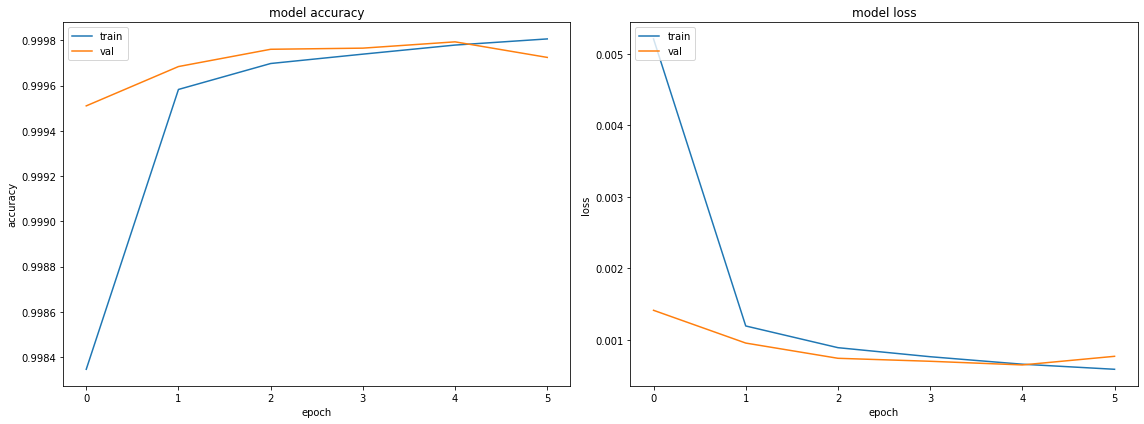

In [52]:
%%time
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)

## multi input
if model_config['aux_feats']['use']:
    print("multi input model")
    history = model.fit([train_dict['lstm_feats'], train_aux], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                    validation_data=([valid_dict['lstm_feats'], valid_aux], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])
else:
    print("single input model")
    history = model.fit(train_dict['lstm_feats'], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                        validation_data=(valid_dict['lstm_feats'], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])

plot_output(history)

In [319]:
eval1_dict['lstm_feats']

array([[   63,     3,     1, ...,    87,     3,     1],
       [10865,     3,     1, ..., 14946,  5559,     2],
       [    3,  4330,    78, ...,     8,   732,    89],
       ...,
       [    2,  1961,  2629, ...,  1913,     3,     4],
       [  148,     9,   112, ...,     3,   861,     9],
       [   20,  4399,  1564, ...,     5,     5,     5]])

In [53]:
print('done')

done


In [ ]:
#ls = [len(sent.split(" ")) for sent in sentences_test]

In [ ]:
#sentences_test[0]

In [66]:
test_dict['labels'].shape

(20784, 100)

### Analysis on validation data

In [80]:
%%time
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
if model_config['aux_feats']['use']:
    valid_probs = model.predict([valid_dict['lstm_feats'], valid_aux])
else:
    valid_probs = model.predict(valid_dict['lstm_feats'])

valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
valid_preds = np.where(valid_probs > 0.5, 1, 0)

valid_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_dict['labels'], yvalid)]
valid_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_preds, yvalid)]
result_valid = evaluate(valid_true_ls, valid_pred_ls)

CPU times: user 8.54 s, sys: 418 ms, total: 8.95 s
Wall time: 8.93 s


In [55]:
result_valid

{'count': 18656,
 'count_citations': 45547,
 'mean_acc': 0.9996739582395737,
 'num_mistakes_seq': 498,
 'num_mistakes_all': 521,
 'mistakes_per_seq': 1.0461847389558232,
 'perc_mistakes_seq': 2.6693825042881647,
 'mistake_per_citation': 1.1438733615825412}

In [101]:
valid_preds_win = []
for ind in range(len(valid_preds)):
    valid_preds_win.append(valid_preds[ind][0:len(xvalid[ind].split(" "))])

In [ ]:
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
count_valid = 0
#valid_df = pd.DataFrame([])
valid_ls = []
for ind in range(len(valid_preds)):
    temp_ls = []
    pred = valid_preds[ind]
    true = valid_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            for x in fp_ind:
                valid_ls.append([ind, 'FP'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                valid_ls.append([ind, 'FN'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])

In [ ]:
valid_mistakes_df = pd.DataFrame(valid_ls, columns=['index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

### Analysis of test result

In [70]:
%%time
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/1d953e89279b49fdb63cd7b3cb6c8b0b/artifacts/models")
if model_config['aux_feats']['use']:
    test_probs = model.predict([test_dict['lstm_feats'], test_aux])
else:
    test_probs = model.predict(test_dict['lstm_feats'])
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)
# test_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_dict['labels'], sent_tags_test_win)]
# test_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_preds, sent_tags_test_win)]
# result_test = evaluate(test_true_ls, test_pred_ls)

CPU times: user 9.87 s, sys: 620 ms, total: 10.5 s
Wall time: 10.1 s


In [415]:
result_test

{'count': 1953,
 'count_citations': 46096,
 'mean_ser': 0.002241456410969765,
 'mean_jer': 0.002638789754513284,
 'mean_acc': 0.9998595911808738,
 'num_mistakes_seq': 179,
 'num_mistakes_all': 211,
 'mistakes_per_seq': 1.1787709497206704,
 'perc_mistakes_seq': 9.165386584741423,
 'mistake_per_citation': 0.45774036792780287}

In [293]:
%%time
take_mean = True
test_probs_win = []
for ind in range(len(test_probs)):
    #print(ind)
    test_probs_win.append(test_probs[ind][0:len(sentences_test_win[ind].split(" "))])

test_probs_merged = []
window = 100
step = 90
gind = 0
for bigind in range(len(sentences_test)):
    temp = []
    seqlen =  len(sentences_test[bigind].split(" "))
    iter = 0
    #print(seqlen)
    #print(bigind)
    for smallind in range(gind, len(test_probs_win)):
        if len(temp) < seqlen:
            if iter ==0:
                temp+=test_probs_win[gind].tolist()
                iter +=1
                gind += 1
            else:
                if take_mean:
                    temp[-(window-step):] = np.mean([np.array(temp[-(window-step):]), test_probs_win[gind][0:(window-step)]], axis=0).tolist()
                    temp += test_probs_win[gind][(window-step):].tolist()
                    gind += 1
                else:
                    temp+=test_probs_win[gind][(window-step):].tolist()
                    gind += 1
        else:
            break
    test_probs_merged.append(temp)

tag2index = {'B-CIT':1, 'I-CIT':0}
test_preds_merged = [[int(t>0.5) for t in test_probs_merged[ind]] for ind in range(len(test_probs_merged))]
test_true_merged = [[tag2index[t] for t in sent_tags_test[ind].split(" ")] for ind in range(len(sent_tags_test))]

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.48 s


In [398]:
#result_test = evaluate(test_true_merged, test_preds_merged)

In [295]:
#result_test

{'count': 1953,
 'count_citations': 46096,
 'mean_acc': 0.9998595911808738,
 'num_mistakes_seq': 179,
 'num_mistakes_all': 211,
 'mistakes_per_seq': 1.1787709497206704,
 'perc_mistakes_seq': 9.165386584741423,
 'mistake_per_citation': 0.45774036792780287}

In [270]:
#result_test

{'count': 1953,
 'count_citations': 46096,
 'mean_acc': 0.999835077363325,
 'num_mistakes_seq': 211,
 'num_mistakes_all': 249,
 'mistakes_per_seq': 1.180094786729858,
 'perc_mistakes_seq': 10.80389144905274,
 'mistake_per_citation': 0.5401770218674071}

In [416]:
%%time
tags = {'dataset':'cs_mixed_20k', 'data_split':'test', 'version':2} 
del model_config['embedding']['matrix'] 
opt = model_config['optimizer']
model_config['optimizer'] = str(opt.get_config())
log_mlflow_results(model, result_test, feat_config, model_config, tags)

2020/09/02 15:00:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://caps-s3-mlflow/artifacts/4/bf735af94c3946b1b27cacbedfea408e/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


In [400]:
count_test = 0
test_ls = []
for ind in range(len(test_preds_merged)):
    temp_ls = []
    pred = np.array(test_preds_merged[ind])
    true = np.array(test_true_merged[ind])
    if (true == pred).all():
        pass
    else:
        count_test += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(ind, 'fp', fp_ind)
            for x in fp_ind:
                ls = ['None']*7
                if max(0, x-3)==0:
                    ls[3-x:] = np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist()
                else:
                    ls = np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist()
                test_ls.append([ind, x, 'FP'] + ls)
                #print(ind, 'FP', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            #print(ind, 'fn', fn_ind)
            for x in fn_ind:
                ls = ['None']*7
                if max(0, x-3)==0:
                    ls[3-x:] = np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist()
                else:
                    ls = np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist()
                test_ls.append([ind, x, 'FN'] + ls)
                #print(ind, 'FN', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])

In [401]:
test_mistakes_df = pd.DataFrame(test_ls, columns=['seq_index', 'token_index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [402]:
test_mistakes_df = test_mistakes_df.replace('\n', 'newline')

In [407]:
#test_mistakes_df

In [408]:
test_mistakes_df.to_csv('../test_mistakes_window1.csv')

In [ ]:
#test_mistakes_df[test_mistakes_df.error_type == 'FP']

### Analysis of eval dataset

In [ ]:
%%time
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/1d953e89279b49fdb63cd7b3cb6c8b0b/artifacts/models")

In [321]:
if model_config['aux_feats']['use']:
    print('auxiliary features ...')
    eval1_probs = model.predict([eval1_dict['lstm_feats'], eval1_aux])
else:
    print('only lstm features ...')
    eval1_probs = model.predict(eval1_dict['lstm_feats'])
eval1_probs = eval1_probs.reshape(eval1_probs.shape[0], eval1_probs.shape[1])
eval1_preds = np.where(eval1_probs > 0.5, 1, 0)


eval1_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_dict['labels'], sent_tags_eval1_win)]
eval1_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_preds, sent_tags_eval1_win)]
result_eval1 = evaluate(eval1_true_ls, eval1_pred_ls)

only lstm features ...


In [417]:
result_eval1

{'count': 1328,
 'count_citations': 56850,
 'mean_acc': 0.9998530866974515,
 'num_mistakes_seq': 300,
 'num_mistakes_all': 344,
 'mistakes_per_seq': 1.1466666666666667,
 'perc_mistakes_seq': 22.59036144578313,
 'mistake_per_citation': 0.6051011433597185}

In [ ]:
result_eval1

In [418]:
%%time
take_mean = True
eval1_probs_win = []
for ind in range(len(eval1_probs)):
    #print(ind)
    eval1_probs_win.append(eval1_probs[ind][0:len(sentences_eval1_win[ind].split(" "))])

eval1_probs_merged = []
window = 100
step = 90
gind = 0
for bigind in range(len(sentences_eval1)):
    temp = []
    seqlen =  len(sentences_eval1[bigind].split(" "))
    iter = 0
    #print(seqlen)
    #print(bigind)
    for smallind in range(gind, len(eval1_probs_win)):
        if len(temp) < seqlen:
            if iter ==0:
                temp+=eval1_probs_win[gind].tolist()
                iter +=1
                gind += 1
            else:
                if take_mean:
                    temp[-(window-step):] = np.mean([np.array(temp[-(window-step):]), eval1_probs_win[gind][0:(window-step)]], axis=0).tolist()
                    temp += eval1_probs_win[gind][(window-step):].tolist()
                    gind += 1
                else:
                    temp+=eval1_probs_win[gind][(window-step):].tolist()
                    gind += 1
        else:
            break
    eval1_probs_merged.append(temp)

tag2index = {'B-CIT':1, 'I-CIT':0}
eval1_preds_merged = [[int(t>0.5) for t in eval1_probs_merged[ind]] for ind in range(len(eval1_probs_merged))]
eval1_true_merged = [[tag2index[t] for t in sent_tags_eval1[ind].split(" ")] for ind in range(len(sent_tags_eval1))]

CPU times: user 2.15 s, sys: 6.84 ms, total: 2.15 s
Wall time: 2.13 s


In [419]:
result_eval1 = evaluate(eval1_true_merged, eval1_preds_merged)

In [420]:
result_eval1

{'count': 1328,
 'count_citations': 56850,
 'mean_ser': 0.0007637693631669535,
 'mean_jer': 0.006231187644864529,
 'mean_acc': 0.9998530866974515,
 'num_mistakes_seq': 300,
 'num_mistakes_all': 344,
 'mistakes_per_seq': 1.1466666666666667,
 'perc_mistakes_seq': 22.59036144578313,
 'mistake_per_citation': 0.6051011433597185}

### Visualize errors

In [365]:
count_eval1 = 0
eval1_ls = []
for ind in range(len(eval1_preds_merged)):
    temp_ls = []
    pred = np.array(eval1_preds_merged[ind])
    true = np.array(eval1_true_merged[ind])
    if (true == pred).all():
        pass
    else:
        count_eval1 += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(ind, 'fp', fp_ind)
            for x in fp_ind:
                ls = ['None']*7
                if max(0, x-3)==0:
                    ls[3-x:] = np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist()
                else:
                    ls = np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist()
                eval1_ls.append([ind, x, 'FP'] + ls)
                #print(ind, 'FP', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            #print(ind, 'fn', fn_ind)
            for x in fn_ind:
                ls = ['None']*7
                if max(0, x-3)==0:
                    ls[3-x:] = np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist()
                else:
                    ls = np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist()
                eval1_ls.append([ind, x, 'FN'] + ls)
                #print(ind, 'FN', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])

In [366]:
#eval1_ls

In [367]:
eval_mistakes_df = pd.DataFrame(eval1_ls, columns=['seq_index', 'token_index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [410]:
eval_mistakes_df = eval_mistakes_df.replace('\n', 'newline')

In [412]:
eval_mistakes_df.shape

(344, 10)

In [ ]:
sentences_eval1[180].split(" ")[1880]

In [ ]:
eval1_dict['lstm_feats'][180][1879]

In [ ]:
tokenizer.word_index['.']

In [ ]:
eval1_dict['spacy_num_feats'][180][1880]

In [ ]:
"IS_ALPHA",  "IS_ASCII", "IS_DIGIT",
            "IS_LOWER",  "IS_UPPER", "IS_TITLE", 
            "IS_PUNCT",  "IS_SPACE", "IS_STOP", 
            "LIKE_NUM",  "LIKE_URL", "LIKE_EMAIL", #"LENGTH",
        ]

In [ ]:
eval1_parscit_arr[180][1879]

In [389]:
# for ind in range(100):
#     print(sentences_train[ind].split(" ")[0])

In [388]:
eval1_dict['lstm_feats'][0]

array([   63,     3,     1,    78,     2, 11609,   171,     2,  2422,
         179,     2,   512,  3094,     2,     1,  3550,     3, 40789,
       11617,     1,    10,  2244, 12023,    12, 95607,    10,  3636,
           7,  4653,  1668,     7, 18394,    43,    10,  1626,  4392,
         292,  8221,     3, 34022,     3,     1,     7,   135,     3,
           4,    84,     3,     1,   201,     2,  1504,  2010,     2,
        7020,   185,     2,     1,   212,     2,  4171,    57,     2,
        1124,  5467,     2,     1,   253,     2, 14649,  5467,     3,
         379,    71,     8, 11617,  5507,     1,    38,   292,     7,
       11507, 20550,    43,  5540, 11221,  5456, 10545, 59296,     3,
       10865,     3,     1,     7,  1199,     3,     4,    87,     3,
           1])

In [390]:
tn, fp, fn, tp = confusion_matrix(y_true=eval1_true_merged[0], y_pred=eval1_preds_merged[0]).ravel()

In [413]:
eval_mistakes_df.to_csv('../eval_mistakes_window1.csv', index=False)

### Save eval results to file

In [ ]:
ind = 0
eval_path_dict = {}
for fpath in os.listdir(eval_without_intra_newline_path):
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        eval_path_dict[ind] = fpath
        ind += 1

In [ ]:
eval_folder_path = '/nlp/eval_data_retok_predictions_f3a9cc61e30f460499b95a4c2b7957ae'
if not os.path.exists(eval_folder_path):
    os.makedirs(eval_folder_path)
for ind in range(len(eval_preds1)):
    #print(ind)
    df = pd.DataFrame([], columns=['x', 'y'])
    seq_len = min(len(sentences_eval1[ind].split(" ")), maxlen)
    df['x'] = sentences_eval1[ind].split(" ")[0:seq_len]
    df['y'] = eval_preds1[ind][0:seq_len]
    df.to_csv(os.path.join(eval_folder_path, eval_path_dict[ind][0:-4] + '_pred.csv'))

### Log Eval results to MLFlow

In [421]:
tags = {'dataset':'cs_mixed_20k', 'data_split':'eval_with_intra_newline_path','version':2}
#del model_config['embedding']['matrix'] 
#opt = model_config['optimizer']
#model_config['optimizer'] = str(opt.get_config())
log_mlflow_results(model, result_eval1, feat_config, model_config, tags)

2020/09/02 15:02:25 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://caps-s3-mlflow/artifacts/4/59e06c5ff45944f5bf56745b2e19cb05/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


### Saving features to file

In [ ]:
# %%time
# np.save('/nlp/temp/train_dict_labels.npy', train_dict['labels'])
# np.save('/nlp/temp/train_dict_lstm_feats.npy', train_dict['lstm_feats'])
# np.save('/nlp/temp/train_dict_spacy_feats.npy', train_dict['spacy_num_feats'])

# np.save('/nlp/temp/valid_dict_labels.npy', valid_dict['labels'])
# np.save('/nlp/temp/valid_dict_lstm_feats.npy', valid_dict['lstm_feats'])
# np.save('/nlp/temp/valid_dict_spacy_feats.npy', valid_dict['spacy_num_feats'])

# np.save('/nlp/temp/test_dict_labels.npy', test_dict['labels'])
# np.save('/nlp/temp/test_dict_lstm_feats.npy', test_dict['lstm_feats'])
# np.save('/nlp/temp/test_dict_spacy_feats.npy', test_dict['spacy_num_feats'])

In [ ]:
# np.save('/nlp/temp/eval1_dict_labels.npy', eval1_dict['labels'])
# np.save('/nlp/temp/eval1_dict_lstm_feats.npy', eval1_dict['lstm_feats'])
# np.save('/nlp/temp/eval1_dict_spacy_feats.npy', eval1_dict['spacy_num_feats'])

In [ ]:
import re

In [ ]:
sentences_eval1[0]

In [ ]:
bla = re.search('\n [0-9]+ .', sentences_eval1[0]).start()

In [ ]:
bla

In [ ]:
for ind in range(100):
    print(np.array(xtrain[ind].split(" "))[np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')])

In [ ]:
for ind in range(100):
    print(ind, '----->', sentences_train[ind][0:500])

In [ ]:
np.where(np.array(sent_tags_train[0].split(" ")) == "B-CIT")

In [ ]:
# string = sentences_eval1[0]
# pattern = '\n [a-zA-Z0-9]+ .'

In [ ]:
#re.findall(pattern, sentences_eval1[2])

In [ ]:
# for ind in range(1000):
#     bind = np.where(np.array(sent_tags_eval1[ind].split(" ")) == 'B-CIT')
#     for b in bind[0][0:3]:
#         print(b)
#         print(sentences_eval1[ind].split(" ")[max(0, b-2): b+3])

In [ ]:
for ind in range(1000):
    bind = np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')
    for b in bind[0][0:3]:
        print(b)
        print(xtrain[ind].split(" ")[max(0, b-4): b+5])

In [ ]:
ind = 6
np.where(train_custom_arr[ind].reshape(1,-1)[0] == 1)

In [ ]:
np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')

In [ ]:
xtrain[ind]

In [ ]:
xtrain[ind].split(" ")[246:252]

In [233]:
np.mean([np.array([1,2]), np.array([4,5])], axis=0)

array([2.5, 3.5])

In [304]:
count = 0
for x in range(len(sentences_eval1)):
    if len(sentences_eval1[x].split(" "))> 3861:
        count += 1

In [305]:
count

52